In [9]:
import pyspark
from pyspark.sql import SparkSession
import sys
import numpy as np
from pyspark.sql.functions import lit, monotonically_increasing_id
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

In [10]:
spark = SparkSession.builder \
    .appName("FlightPricePrediction_LinearRegression") \
    .getOrCreate()

In [11]:
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/home/godwolf/Downloads/flightprice/Clean_Dataset.csv")

df.show()

24/06/05 10:07:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , airline, flight, source_city, departure_time, stops, arrival_time, destination_city, class, duration, days_left, price
 Schema: _c0, airline, flight, source_city, departure_time, stops, arrival_time, destination_city, class, duration, days_left, price
Expected: _c0 but found: 
CSV file: file:///home/godwolf/Downloads/flightprice/Clean_Dataset.csv


+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3|  Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4|  Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  5|  Vistara| UK-945|      Del

In [12]:
df = df.drop("_c0")

In [13]:
df.show()

+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  Vistara| UK-945|      Delhi|       Morning| zero|    Afternoo

In [14]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# Convert "airline", "flight", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class" column to numerical labels
indexer = StringIndexer(inputCols=["airline", "flight", "source_city", 
                                   "departure_time", "stops", "arrival_time", 
                                   "destination_city", "class"], 
                        outputCols=["Airline", "Flight", "Source_city", "Departure_time", 
                                    "Stops", "Arrival_time", "Destination_city", "Class"])
model = indexer.fit(df)
df_indexed = model.transform(df)

# Display the resulting DataFrame
df_indexed.show()

+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|Airline|Flight|Source_city|Departure_time|Stops|Arrival_time|Destination_city|Class|duration|days_left|price|
+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|    5.0| 452.0|        0.0|           2.0|  1.0|         0.0|             0.0|  0.0|    2.17|        1| 5953|
|    5.0| 461.0|        0.0|           1.0|  1.0|         2.0|             0.0|  0.0|    2.33|        1| 5953|
|    4.0| 566.0|        0.0|           1.0|  1.0|         4.0|             0.0|  0.0|    2.17|        1| 5956|
|    0.0|  74.0|        0.0|           0.0|  1.0|         3.0|             0.0|  0.0|    2.25|        1| 5955|
|    0.0|  81.0|        0.0|           0.0|  1.0|         2.0|             0.0|  0.0|    2.33|        1| 5955|
|    0.0|  88.0|        0.0|           0.0|  1.0|         3.0|             0.0|  0.0|    2.33|        1| 5955|
|

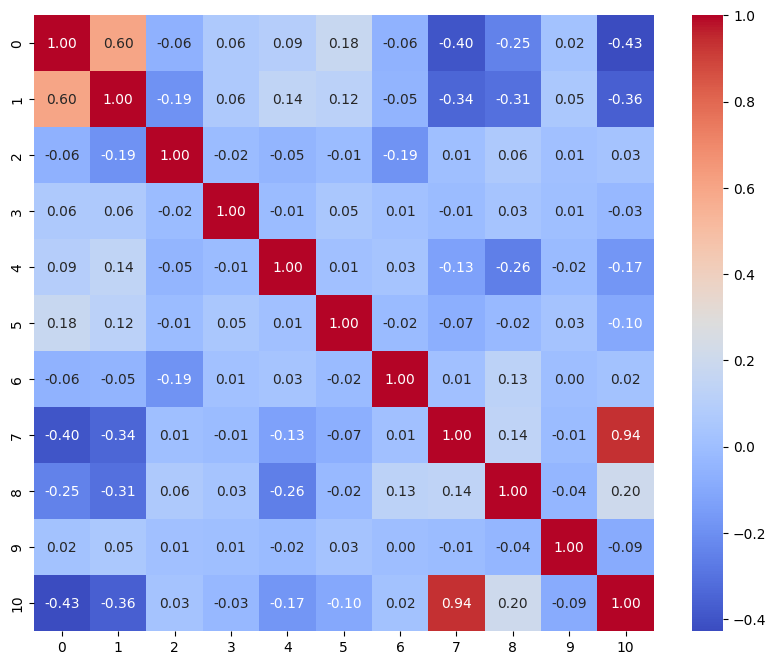

In [15]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble data into vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_indexed.columns, outputCol=vector_col)
df_vector = assembler.transform(df_indexed).select(vector_col)

# Calculate correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
correlation_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].toArray()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [16]:
df_new = df_indexed.drop("Class", "Stops", "Days_left", "Airline", "Duration", "Arrival_time")

In [17]:
df_new.printSchema()

root
 |-- Flight: double (nullable = false)
 |-- Source_city: double (nullable = false)
 |-- Departure_time: double (nullable = false)
 |-- Destination_city: double (nullable = false)
 |-- price: integer (nullable = true)



In [18]:
def CalculateXTX(row):
    # Convert the input row to a NumPy array
    value_X = np.array(row[1:], dtype='float')
    
    # Form a row matrix from the values of X
    matX = np.matrix(value_X)
    
    # Insert value 1 at the 0th position of the row matrix
    X = np.insert(matX, 0, 1, axis=1)
    
    # Calculate the transpose of X
    transpose_X = X.T
    
    # Calculate X * transpose(X)
    XTX = np.dot(transpose_X, X)
    
    return XTX

def CalculateXTY(row):
    # Convert the input row to a NumPy array
    value_X = np.array(row[1:-1], dtype='float')
    value_Y = row[-1]
    
    # Form a row matrix from the values of X
    matX = np.matrix(value_X)
    
    # Insert value 1 at the 0th position of the row matrix
    X = np.insert(matX, 0, 1, axis=1)
    
    # Calculate the transpose of X
    transpose_X = X.T
    
    # Form a row matrix from the value of Y
    Y = np.matrix([value_Y])
    
    # Calculate transpose(X) * Y
    XTY = np.dot(transpose_X, Y)
    
    return XTY

In [19]:
df_new.printSchema()

root
 |-- Flight: double (nullable = false)
 |-- Source_city: double (nullable = false)
 |-- Departure_time: double (nullable = false)
 |-- Destination_city: double (nullable = false)
 |-- price: integer (nullable = true)



In [20]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
# 80% dữ liệu để huấn luyện, 20% để kiểm thử
train_ratio = 0.8
test_ratio = 1 - train_ratio
seed = 42  

# Sử dụng randomSplit để chia tập dữ liệu
train_data, test_data = df_new.randomSplit([train_ratio, test_ratio], seed=seed)

In [21]:
# Lấy danh sách cột đặc trưng
feature = ["Flight", "Source_city", "Departure_time", "Destination_city"]

feature_columns = train_data["Flight", "Source_city", "Departure_time", "Destination_city"]

# Thêm cột mới có giá trị là 1
feature_columns = feature_columns.withColumn("intercept", lit(1.0))
##feature_columns = feature_columns.withColumn("intercept", lit(1.0))

# Reorder lại cột để cột "intercept" xuất hiện đầu tiên
feature_columns = feature_columns.select(["intercept"] + feature)

# Hiển thị DataFrame mới
feature_columns.show()


+---------+------+-----------+--------------+----------------+
|intercept|Flight|Source_city|Departure_time|Destination_city|
+---------+------+-----------+--------------+----------------+
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|             0.0|
|      1.0|   0.0|        0.0|           4.0|          

In [22]:
# Lấy danh sách cột đặc trưng
feature = ["Flight", "Source_city", "Departure_time", "Destination_city"]

feature_columnsy = train_data

# Thêm cột mới có giá trị là 1
feature_columnsy = feature_columnsy.withColumn("intercept", lit(1.0))

# Reorder lại cột để cột "intercept" xuất hiện đầu tiên
feature_columnsy = feature_columnsy.select(["intercept"] + feature + ["price"])

# Hiển thị DataFrame mới
feature_columnsy.show()

+---------+------+-----------+--------------+----------------+-----+
|intercept|Flight|Source_city|Departure_time|Destination_city|price|
+---------+------+-----------+--------------+----------------+-----+
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|           4.0|             0.0| 4381|
|      1.0|   0.0|        0.0|    

In [23]:
# Tinh transpose(X) * X
XTX = np.array(feature_columns.rdd.map(CalculateXTX).reduce(lambda a, b: np.add(a, b)))

# inversert X * X
inverseXTX = np.linalg.inv(XTX)


# tinh transpose(X) * Y
XTY = np.array(feature_columnsy.rdd.map(CalculateXTY).reduce(lambda a, b: np.add(a, b)))

# ket qua beta
beta = np.dot(inverseXTX, XTY)

print("beta: ")
for coeff in beta:
    print(coeff)

beta: 
[29458.46187662]
[-30.95636228]
[-622.43520288]
[-99.29477485]
[-104.90474153]


In [24]:
df1 = test_data.drop("price")
# Chuyển DataFrame thành RDD
rdd = df1.rdd

# Duyệt qua từng dòng của RDD và tính toán
for row in rdd.collect():
    flight_index = row["Flight"]
    source_city_index = row["Source_city"]
    departure_time_index = row["Departure_time"]
    destination_city_index = row["Destination_city"]

    # Thực hiện tính toán dựa trên các giá trị thuộc tính
    result = beta[0] * flight_index + beta[1] * source_city_index \
    + beta[2] * departure_time_index + beta[3] * destination_city_index + beta[4] 
    print("Result:", result)

Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2594.64555306]
Result: [-2793.23510276]
Result: [-2793.23510276]
Result: [-2892.52987761]
Result: [-2991.82465246]
Result: [-2991.82465246]
Result: [-2991.82465246]
Result: [556985.87896559]
Result: [556985.87896559]
Result: [556985.87896559]
Result: [556886.58419074]
Result: [556886.58419074]
Result: [556886.58419074]
Result: [556886.58419074]
Result: [556787.28941589]
Result: [556787.28941589]
Result: [556787.28941589]
Result: [556787.28941589]
Result: [556787.28941589]
Result: [556787.28941589]
Result: [556687.99464104]
Result: [556687.99464104]
Result: [556687.99464104]
Result: [556687.99464104]
Result: 

Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1441587.42657055]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
Result: [1471511.40595914]
R

Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912991.15500904]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1912891.86023419]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941533.58716673]
Result: [1941434.29239188]
Result: [1941434.29239188]
Result: [1941434.29239188]
Result: [1941434.29239188]
Result: [1941434.29239188]
R

Result: [2179622.68457865]
Result: [2179622.68457865]
Result: [2179622.68457865]
Result: [2179622.68457865]
Result: [2179622.68457865]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179523.3898038]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179424.09502895]
Result: [2179324.8002541]
Result: [2179324.800

Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620647.63161308]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2620548.33683823]
Result: [2648666.92334274]
Result: [2648666.92334274]
Result: [2648666.92334274]
R

Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3946084.11631978]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945885.52677008]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945786.23199523]
Result: [3945686.93722038]
R

Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5300153.74834202]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361335.1568033]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361136.5672536]
Result: [5361037.27247875]
Result: [5361037.27247875]
Result: [5361037.27247875]
Result: [5361037.27247875]
Result: [5360937.9777039]
Result: [5360937.9777039]
Result: [5360937.9777039]
Result: [5360937.9777039]

Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186384.67161084]
Result: [7186285.37683599]
Result: [7186285.37683599]
Result: [7186285.37683599]
Result: [7186285.37683599]
Result: [7186285.37683599]
Result: [7186285.37683599]
Result: [7186285.37683599]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186186.08206114]
Result: [7186086.78728629]
Result: [7186086.78728629]
Result: [7186086.78728629]
Result: [7186086.78728629]
R

Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8807191.55366554]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8806992.96411584]
Result: [8866139.43378106]
Result: [8866139.43378106]
Result: [8866139.43378106]
R

Result: [10484388.23661166]
Result: [10484388.23661166]
Result: [10484388.23661166]
Result: [10484388.23661166]
Result: [10484388.23661166]
Result: [10484388.23661166]
Result: [10484388.23661166]
Result: [10484288.94183681]
Result: [10484288.94183681]
Result: [10484288.94183681]
Result: [10484288.94183681]
Result: [10484288.94183681]
Result: [10484288.94183681]
Result: [10484288.94183681]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10484189.64706196]
Result: [10515943.55000891]
Result: [10515943.55000891]
Result: [10515943.55000891]
Result: [10515943.55000891]
Result: [10515744.96045921]
Result: [10515744.96045921]
Result: [10515744.96045921]
Result: [10515744.96045921]
Result: [10515744.96045921]
Result: [10515744.96045921]
Result: [10515744.96045921]
Result: [10515744.96

Result: [12842864.15393734]
Result: [12842864.15393734]
Result: [12842864.15393734]
Result: [12842864.15393734]
Result: [12842864.15393734]
Result: [12842864.15393734]
Result: [12842864.15393734]
Result: [12842665.56438764]
Result: [12842665.56438764]
Result: [12870622.94339273]
Result: [12870622.94339273]
Result: [12870622.94339273]
Result: [12870622.94339273]
Result: [12870622.94339273]
Result: [12870622.94339273]
Result: [12870622.94339273]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870523.64861788]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05906818]
Result: [12870325.05

Result: [15198788.41772692]
Result: [15198788.41772692]
Result: [15198788.41772692]
Result: [15198788.41772692]
Result: [15198788.41772692]
Result: [15198788.41772692]
Result: [15198788.41772692]
Result: [15198689.12295207]
Result: [15198689.12295207]
Result: [15198689.12295207]
Result: [15198689.12295207]
Result: [15198689.12295207]
Result: [15198689.12295207]
Result: [15198689.12295207]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15229167.19913097]
Result: [15228968.60958127]
Result: [15258693.99942015]
Result: [15258693.99942015]
Result: [15258594.70464531]
Result: [15258594.70464531]
Result: [15258594.70464531]
Result: [15258594.70464531]
Result: [15258594.70464531]
Result: [15258594.70464531]
Result: [15258594.70

Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19000441.79817892]
Result: [19117191.98277906]
Result: [19117191.98277906]
Result: [19117191.98277906]
Result: [19117191.98277906]
Result: [19117191.98277906]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87985856]
Result: [19147272.87

Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25892801.55778056]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [25951817.77630865]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26010472.06190812]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26038387.76905443]
Result: [26070011.42

Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77382838]
Result: [-197.77

Result: [232918.26764848]
Result: [232918.26764848]
Result: [232918.26764848]
Result: [232918.26764848]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232818.97287364]
Result: [232

Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587528.00374856]
Result: [587

Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382345.95193898]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1382246.65716413]
Result: [1412526.14379333]
Result: [1412526.14379333]
Result: [1412526.14379333]
Result: [1412526.14379333]
Result: [1412526.14379333]
Result: [1412526.14379333]
Result: [1412526.14379333]
Result: [1412526.14379333]
R

Result: [2679072.37130057]
Result: [2679072.37130057]
Result: [2679072.37130057]
Result: [2679072.37130057]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678973.07652572]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
Result: [2678873.78175087]
R

Result: [3770280.33114127]
Result: [3770280.33114127]
Result: [3770280.33114127]
Result: [3770280.33114127]
Result: [3770280.33114127]
Result: [3770280.33114127]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3770181.03636643]
Result: [3767964.64920516]
Result: [3767964.64920516]
Result: [3767964.64920516]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
Result: [3799283.99100243]
R

Result: [5005469.83480097]
Result: [5005469.83480097]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5036047.20575472]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5035848.61620502]
Result: [5095456.31357371]
Result: [5095456.31357371]
Result: [5095456.31357371]
R

Result: [7422712.18387697]
Result: [7422712.18387697]
Result: [7422712.18387697]
Result: [7422712.18387697]
Result: [7422712.18387697]
Result: [7422712.18387697]
Result: [7422712.18387697]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422612.88910212]
Result: [7422513.59432727]
Result: [7422513.59432727]
Result: [7422513.59432727]
Result: [7422513.59432727]
Result: [7422513.59432727]
Result: [7422513.59432727]
Result: [7422315.00477757]
Result: [7422315.00477757]
Result: [7422315.00477757]
Result: [7422315.00477757]
Result: [7422315.00477757]
Result: [7422315.00477757]
Result: [7422315.00477757]
R

Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10544781.71256215]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575390.03987818]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74510333]
Result: [10575290.74

Result: [18793025.07668711]
Result: [18792727.19236256]
Result: [18792727.19236256]
Result: [18792727.19236256]
Result: [18792727.19236256]
Result: [18792727.19236256]
Result: [18792727.19236256]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821730.85222371]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18821532.26267401]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00044034]
Result: [18851942.00

Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]
Result: [58096.71472198]


Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321126.02009093]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321026.72531608]
Result: [321

Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [647197.61384181]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646999.02429211]
Result: [646

Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795211.65320264]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [795112.35842779]
Result: [794

Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1235285.32434736]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265302.1728228]
Result: [1265202.87804795]
Result: [1265202.87804795]
Result: [

Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002741.66218179]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002642.36740695]
Result: [2002543.0726321]
Result: [2002543.0726321]
Res

In [25]:
# Tạo một danh sách để chứa các hàng mới
result_rows = []

# Duyệt qua từng dòng của RDD và tính toán
for row in rdd.collect():
    flight_index = row["Flight"]
    source_city_index = row["Source_city"]
    departure_time_index = row["Departure_time"]
    destination_city_index = row["Destination_city"]

    # Thực hiện tính toán dựa trên các giá trị thuộc tính
    result = beta[0] * flight_index + beta[1] * source_city_index \
             + beta[2] * departure_time_index + beta[3] * destination_city_index + beta[4]

    # Tạo một Row mới chứa kết quả
    result_row = Row(y_pred=float(result))

    # Thêm Row vào danh sách
    result_rows.append(result_row)

# Chuyển đổi danh sách Row thành DataFrame
result_df = spark.createDataFrame(result_rows)

# Hiển thị DataFrame chứa kết quả dự đoán
result_df.show()

+-------------------+
|             y_pred|
+-------------------+
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
| -2594.645553059145|
|-2793.2351027574714|
|-2793.2351027574714|
|-2892.5298776066347|
|-2991.8246524557976|
+-------------------+
only showing top 20 rows



In [26]:
test_data.show()

+------+-----------+--------------+----------------+-----+
|Flight|Source_city|Departure_time|Destination_city|price|
+------+-----------+--------------+----------------+-----+
|   0.0|        0.0|           4.0|             0.0| 4381|
|   0.0|        0.0|           4.0|             0.0| 4381|
|   0.0|        0.0|           4.0|             0.0| 4381|
|   0.0|        0.0|           4.0|             0.0| 4381|
|   0.0|        0.0|           4.0|             0.0| 4381|
|   0.0|        0.0|           4.0|             0.0| 4381|
|   0.0|        0.0|           4.0|             0.0| 4673|
|   0.0|        0.0|           4.0|             0.0| 5364|
|   0.0|        0.0|           4.0|             0.0| 7569|
|   0.0|        0.0|           4.0|             0.0| 7569|
|   0.0|        0.0|           4.0|             0.0| 7569|
|   0.0|        0.0|           4.0|             0.0| 9000|
|   0.0|        0.0|           4.0|             0.0| 9000|
|   0.0|        0.0|           4.0|             0.0| 915